<a href="https://colab.research.google.com/github/Suhail-46/Live-PM2.5-Nowcast-and-Forecast-with-Time-series-Analysis/blob/main/Live_PM2_5_Nowcast_and_Forecast_with_Streamlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imported packages required to make request over API and convert it to dataframe with corresponding time
import requests
import pandas as pd
from datetime import datetime, timedelta, timezone

In [2]:
# Provided the coordinates of location to scrape the data from Open-Meteo
lat, lon = 13.0827, 80.2707 # Chennai (change as needed)

In [3]:
# === Function to extract datetime and PM2.5 from Open-Meteo Air Quality ===
def fetch_openmeteo_pm25(lat, lon):
    """Fetch PM2.5 for the past 72 hours (3 days) from Open-Meteo Air Quality API."""
    # Current UTC date
    end_date = datetime.now(timezone.utc)
    # Start date = Last 72 hours
    start_date = end_date - timedelta(hours=72)

    url = "https://air-quality-api.open-meteo.com/v1/air-quality"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "pm2_5",
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d"),
        "timezone": "UTC"
    }

    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    js = r.json()["hourly"]

    df = pd.DataFrame({
        "utc_time": pd.to_datetime(js["time"], utc=True),
        "pm25": js["pm2_5"]
    })
    # Keep only last 72 hours
    df = df[(df["utc_time"] >= start_date) & (df["utc_time"] <= end_date)]
    return df

In [4]:
# Saved the extracted data with dataframe named as pm25_data
pm25_data = fetch_openmeteo_pm25(lat, lon)

In [5]:
# Validated the count of pm25_data extracted from Open-Meteo Air Quality
print(f"Number of hours retrieved: {len(pm25_data)}")

Number of hours retrieved: 72


In [6]:
# Ensured on printing the data frame of pm25_data to validate the range
pm25_data

,utc_time,pm25
7,2025-10-12 07:00:00+00:00,11.9
8,2025-10-12 08:00:00+00:00,11.9
9,2025-10-12 09:00:00+00:00,11.9
10,2025-10-12 10:00:00+00:00,11.7
11,2025-10-12 11:00:00+00:00,12.1
...,...,...
74,2025-10-15 02:00:00+00:00,4.3
75,2025-10-15 03:00:00+00:00,4.0
76,2025-10-15 04:00:00+00:00,4.3
77,2025-10-15 05:00:00+00:00,4.4


In [7]:
# === Function to extract datetime and required variables from Open-Meteo Forecast ===
def fetch_openmeteo_weather(lat, lon):
    """Fetch hourly weather variables from Open-Meteo."""
    # Current UTC date
    end_date = datetime.now(timezone.utc)
    # Start date = Last 72 hours
    start_date = end_date - timedelta(hours=72)

    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "temperature_2m,relativehumidity_2m,windspeed_10m,winddirection_10m,surface_pressure",
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d"),
        "timezone": "UTC"
    }
    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    hourly = r.json()["hourly"]
    df = pd.DataFrame({"utc_time": pd.to_datetime(hourly["time"], utc=True)})
    for k, v in hourly.items():
        if k != "time":
            df[k] = v
    df = df[(df["utc_time"] >= start_date) & (df["utc_time"] <= end_date)]
    return df

In [8]:
# Saved the extracted data and print the count of extracted from Open-Meteo Forecast
whether_data = fetch_openmeteo_weather(lat, lon)
print(f"Number of hours retrieved: {len(whether_data)}")

Number of hours retrieved: 72


In [9]:
# Ensured on printing the data frame of whether_data to validate the range
whether_data

,utc_time,temperature_2m,relativehumidity_2m,windspeed_10m,winddirection_10m,surface_pressure
7,2025-10-12 07:00:00+00:00,32.5,60,9.9,44,1006.1
8,2025-10-12 08:00:00+00:00,32.7,59,10.0,52,1004.9
9,2025-10-12 09:00:00+00:00,32.3,61,9.8,62,1004.7
10,2025-10-12 10:00:00+00:00,31.4,64,10.5,74,1004.2
11,2025-10-12 11:00:00+00:00,30.8,66,9.6,77,1004.5
...,...,...,...,...,...,...
74,2025-10-15 02:00:00+00:00,25.5,94,5.1,8,1007.4
75,2025-10-15 03:00:00+00:00,25.8,92,6.2,21,1008.0
76,2025-10-15 04:00:00+00:00,26.8,88,7.3,33,1008.3
77,2025-10-15 05:00:00+00:00,27.7,88,6.8,32,1007.5


In [10]:
# Merge pm25_data + whether_data (nearest timestamp, 1h tolerance)
merged = pd.merge_asof(
    pm25_data.sort_values("utc_time"),
    whether_data.sort_values("utc_time"),
    on="utc_time",
    direction="nearest",
    tolerance=pd.Timedelta("1h")
    )

In [11]:
# Final data set after web scrape
merged

,utc_time,pm25,temperature_2m,relativehumidity_2m,windspeed_10m,winddirection_10m,surface_pressure
0,2025-10-12 07:00:00+00:00,11.9,32.5,60,9.9,44,1006.1
1,2025-10-12 08:00:00+00:00,11.9,32.7,59,10.0,52,1004.9
2,2025-10-12 09:00:00+00:00,11.9,32.3,61,9.8,62,1004.7
3,2025-10-12 10:00:00+00:00,11.7,31.4,64,10.5,74,1004.2
4,2025-10-12 11:00:00+00:00,12.1,30.8,66,9.6,77,1004.5
...,...,...,...,...,...,...,...
67,2025-10-15 02:00:00+00:00,4.3,25.5,94,5.1,8,1007.4
68,2025-10-15 03:00:00+00:00,4.0,25.8,92,6.2,21,1008.0
69,2025-10-15 04:00:00+00:00,4.3,26.8,88,7.3,33,1008.3
70,2025-10-15 05:00:00+00:00,4.4,27.7,88,6.8,32,1007.5


# **Lags (past snapshots)**

A lag is just the value from a previous time.

It’s like asking: “What was the pollution yesterday at this hour?”

👉 Lags give the model memory of the past.

In [12]:
# Selected lags 1–3 (short + long-term) for 24–48 hr predictions
pm_lags = [1,2,3]  # choose lags depending on forecast horizon
for lag in pm_lags:
    merged[f"pm25_lag{lag}"] = merged["pm25"].shift(lag)

# **Rolling statistics (past trends)**

A rolling mean (average) over the last few hours smooths noise.

E.g., a 3-hour rolling mean tells you the recent trend, not just one spiky value.

A rolling mean tells the model the trend

Example: if the last 6 hours had steadily rising PM2.5, tomorrow is likely to also be high.

👉 Rolling stats give the model a sense of trend + stability.

In [13]:
# Selected rolling statistic(mean) 3–12 (short + long-term) for 24–48 hr predictions
merged['pm25_roll3'] = merged['pm25'].rolling(window=3).mean()
merged['pm25_roll6'] = merged['pm25'].rolling(window=6).mean()
merged['pm25_roll12'] = merged['pm25'].rolling(window=12).mean()

In [14]:
# Ensured target is shifted properly to predict next hour’s PM2.5
merged['target_pm25'] = merged['pm25'].shift(-1)

In [15]:
# Checked the data set after applying lags and rolling stats
merged

,utc_time,pm25,temperature_2m,relativehumidity_2m,windspeed_10m,winddirection_10m,surface_pressure,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll3,pm25_roll6,pm25_roll12,target_pm25
0,2025-10-12 07:00:00+00:00,11.9,32.5,60,9.9,44,1006.1,NaN,NaN,NaN,NaN,NaN,NaN,11.9
1,2025-10-12 08:00:00+00:00,11.9,32.7,59,10.0,52,1004.9,11.9,NaN,NaN,NaN,NaN,NaN,11.9
2,2025-10-12 09:00:00+00:00,11.9,32.3,61,9.8,62,1004.7,11.9,11.9,NaN,11.900000,NaN,NaN,11.7
3,2025-10-12 10:00:00+00:00,11.7,31.4,64,10.5,74,1004.2,11.9,11.9,11.9,11.833333,NaN,NaN,12.1
4,2025-10-12 11:00:00+00:00,12.1,30.8,66,9.6,77,1004.5,11.7,11.9,11.9,11.900000,NaN,NaN,18.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2025-10-15 02:00:00+00:00,4.3,25.5,94,5.1,8,1007.4,4.5,4.5,4.7,4.433333,4.716667,6.016667,4.0
68,2025-10-15 03:00:00+00:00,4.0,25.8,92,6.2,21,1008.0,4.3,4.5,4.5,4.266667,4.483333,5.516667,4.3
69,2025-10-15 04:00:00+00:00,4.3,26.8,88,7.3,33,1008.3,4.0,4.3,4.5,4.200000,4.383333,5.133333,4.4
70,2025-10-15 05:00:00+00:00,4.4,27.7,88,6.8,32,1007.5,4.3,4.0,4.3,4.233333,4.333333,4.866667,3.6


In [16]:
# Handled null values with ffill & bfill to prepare data for machine learning (pre-requisite)
merged.fillna(method='bfill', inplace=True)

/tmp/ipython-input-1054107149.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged.fillna(method='bfill', inplace=True)


In [17]:
merged.fillna(method='ffill', inplace=True)

/tmp/ipython-input-345510778.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged.fillna(method='ffill', inplace=True)


In [18]:
# Checked if any null values are present in dataset
merged.isna().sum()

,0
utc_time,0
pm25,0
temperature_2m,0
relativehumidity_2m,0
windspeed_10m,0
winddirection_10m,0
surface_pressure,0
pm25_lag1,0
pm25_lag2,0
pm25_lag3,0


In [19]:
# Checked the structure of dataset
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   utc_time             72 non-null     datetime64[ns, UTC]
 1   pm25                 72 non-null     float64            
 2   temperature_2m       72 non-null     float64            
 3   relativehumidity_2m  72 non-null     int64              
 4   windspeed_10m        72 non-null     float64            
 5   winddirection_10m    72 non-null     int64              
 6   surface_pressure     72 non-null     float64            
 7   pm25_lag1            72 non-null     float64            
 8   pm25_lag2            72 non-null     float64            
 9   pm25_lag3            72 non-null     float64            
 10  pm25_roll3           72 non-null     float64            
 11  pm25_roll6           72 non-null     float64            
 12  pm25_roll12          72 

In [20]:
# Used IsolationForest algorithm to predict anamolies from dataset
from sklearn.ensemble import IsolationForest
features = ['pm25', 'temperature_2m', 'relativehumidity_2m', 'windspeed_10m', 'surface_pressure',
            'pm25_lag1', 'pm25_lag2', 'pm25_lag3', 'pm25_roll3', 'pm25_roll6', 'pm25_roll12', 'target_pm25']

X = merged[features]

# Initialize IsolationForest
iso = IsolationForest(
    n_estimators=100,      # number of trees
    contamination=0.05,    # fraction of expected anomalies (5% here)
    random_state=42
)

# Fit model
iso.fit(X)

# Predict anomalies
merged['anomaly'] = iso.predict(X)  # -1 = anomaly, 1 = normal

In [21]:
# Checked if any anamoly present in dataset
merged[merged['anomaly'] == -1]

,utc_time,pm25,temperature_2m,relativehumidity_2m,windspeed_10m,winddirection_10m,surface_pressure,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll3,pm25_roll6,pm25_roll12,target_pm25,anomaly
10,2025-10-12 17:00:00+00:00,23.0,26.9,90,1.6,333,1008.5,22.9,21.3,19.8,22.400000,20.766667,16.991667,19.8,-1
11,2025-10-12 18:00:00+00:00,19.8,26.6,92,2.9,277,1008.5,23.0,22.9,21.3,21.900000,21.016667,16.991667,16.8,-1
25,2025-10-13 08:00:00+00:00,18.5,32.9,60,9.7,39,1005.5,20.8,20.3,18.5,19.866667,17.883333,14.766667,15.8,-1
71,2025-10-15 06:00:00+00:00,3.6,28.7,82,9.4,50,1006.6,4.4,4.3,4.0,4.100000,4.183333,4.633333,3.6,-1


In [ ]:
# merged['anomaly_flag'] = merged['anomaly'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')
# merged

In [22]:
# Defined Features and Target columns
# Target variable
y = merged['target_pm25']

# Feature variables (exclude utc_time and pm25 itself)
X = merged.drop(columns=['utc_time', 'pm25', 'target_pm25', 'anomaly'])

In [23]:
# Splited data into Train and Test (train_test_split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
) # Used the first 80% for training and the last 20% for testing.

In [26]:
# Trained Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

# model = GradientBoostingRegressor(
#     n_estimators=500,   # number of trees
#     learning_rate=0.01, # smaller = slower but more accurate
#     max_depth=5,        # depth of each tree
#     random_state=42
# )
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [27]:
# Evaluated model with metrics such as Mean Absolute Error, Mean Squared Error, R2 Score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 2.05
RMSE: 2.85
R²: 0.65


In [28]:
# Prediction of PM2.5 for next hour using the model
y_pred

array([11.9973119 ,  4.7949084 , 10.34205766, 11.87437253, 13.18966465,
       10.34285814, 18.09577922, 11.2700385 , 17.63991717, 10.75802206,
        8.66901281, 14.86089248, 18.70855655,  9.20872284, 14.41223142])

In [29]:
# Converted the model into byte stream(binary) form using pickling
import pickle
pickle.dump(model,open("Whether.pkl","wb"))

In [30]:
# Taken a copy of last row features to feed input for predictions
last_row = merged.iloc[-1].copy()  # Copy the last row as starting point

In [33]:
# Recursive Prediction Loop
forecast_hours = 48  # or 24
predictions = []
for i in range(forecast_hours):
    X_input = last_row.drop(labels=['utc_time', 'pm25', 'target_pm25', 'anomaly']) # exclude non-feature columns
    X_input = X_input.values.reshape(1, -1)  # reshape for model

    y_pred = model.predict(X_input)[0]
    predictions.append(y_pred)

    # Update lags for next iteration
    last_row['pm25_lag3'] = last_row['pm25_lag2']
    last_row['pm25_lag2'] = last_row['pm25_lag1']
    last_row['pm25_lag1'] = y_pred

    # Update rolling mean if used
    last_row['pm25_roll3'] = np.mean([last_row['pm25_lag1'], last_row['pm25_lag2'], last_row['pm25_lag3']])
    last_row['pm25_roll6'] = (last_row['pm25_roll6']*5 + y_pred)/6  # simple rolling update
    last_row['pm25_roll12'] = (last_row['pm25_roll12']*11 + y_pred)/12  # simple rolling update

    # Optional: update utc_time
    last_row['utc_time'] += pd.Timedelta(hours=1)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.w

In [34]:
# Create Forecast DataFrame
forecast_times = [merged['utc_time'].iloc[-1] + pd.Timedelta(hours=i+1) for i in range(forecast_hours)]
forecast_df = pd.DataFrame({
    'utc_time': forecast_times,
    'pm25_pred': predictions
})

In [35]:
# Checked the output of predictions upto 48 hrs
forecast_df

,utc_time,pm25_pred
0,2025-10-15 07:00:00+00:00,3.643073
1,2025-10-15 08:00:00+00:00,3.643073
2,2025-10-15 09:00:00+00:00,3.692733
3,2025-10-15 10:00:00+00:00,3.692733
4,2025-10-15 11:00:00+00:00,3.692733
5,2025-10-15 12:00:00+00:00,3.692733
6,2025-10-15 13:00:00+00:00,3.692733
7,2025-10-15 14:00:00+00:00,3.692733
8,2025-10-15 15:00:00+00:00,3.692733
9,2025-10-15 16:00:00+00:00,3.692733


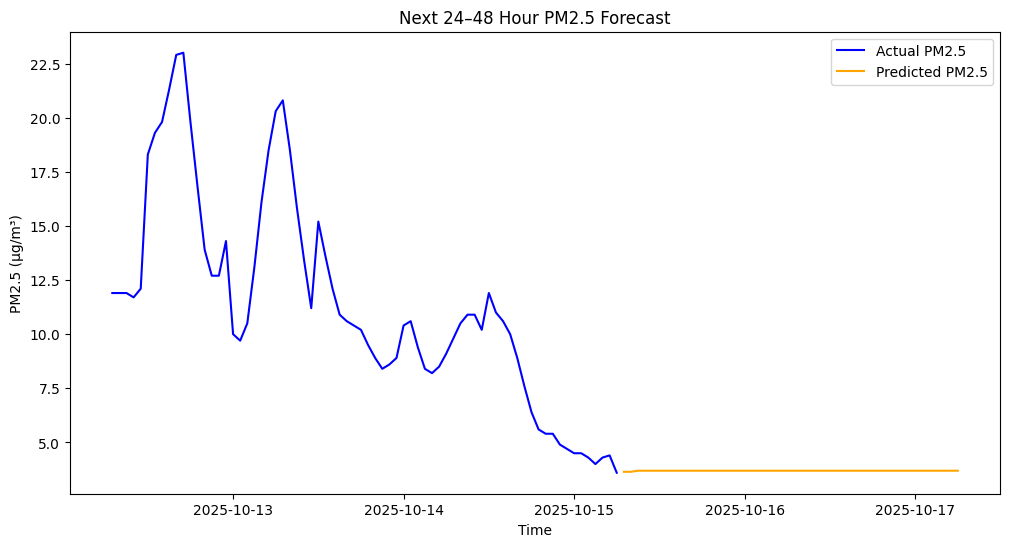

In [36]:
# Visualized Predictions vs Actual
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(merged['utc_time'], merged['pm25'], label='Actual PM2.5', color='blue')
plt.plot(forecast_df['utc_time'], forecast_df['pm25_pred'], label='Predicted PM2.5', color='orange')
plt.title('Next 24–48 Hour PM2.5 Forecast')
plt.xlabel('Time')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.show()

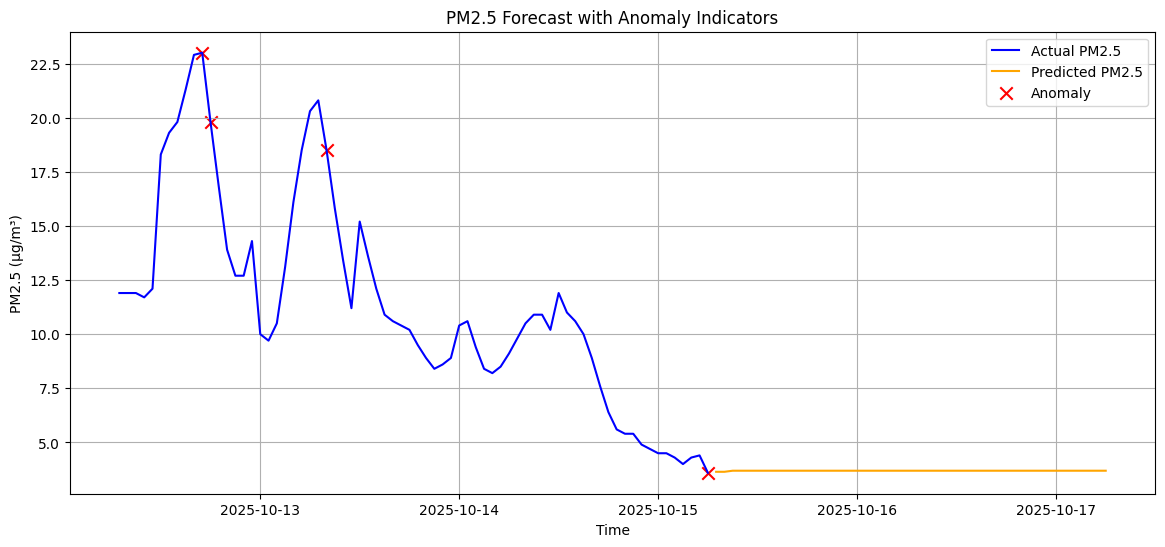

In [37]:
# Visualized Predictions vs Actual with Anomalies
plt.figure(figsize=(14,6))

# Plot historical PM2.5
plt.plot(merged['utc_time'], merged['pm25'], label='Actual PM2.5', color='blue')

# Plot forecasted PM2.5
plt.plot(forecast_df['utc_time'], forecast_df['pm25_pred'], label='Predicted PM2.5', color='orange')

# Highlight anomalies in historical data
anomaly_points = merged[merged['anomaly'] == -1]
plt.scatter(anomaly_points['utc_time'], anomaly_points['pm25'],
            color='red', label='Anomaly', marker='x', s=80)

plt.title('PM2.5 Forecast with Anomaly Indicators')
plt.xlabel('Time')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()

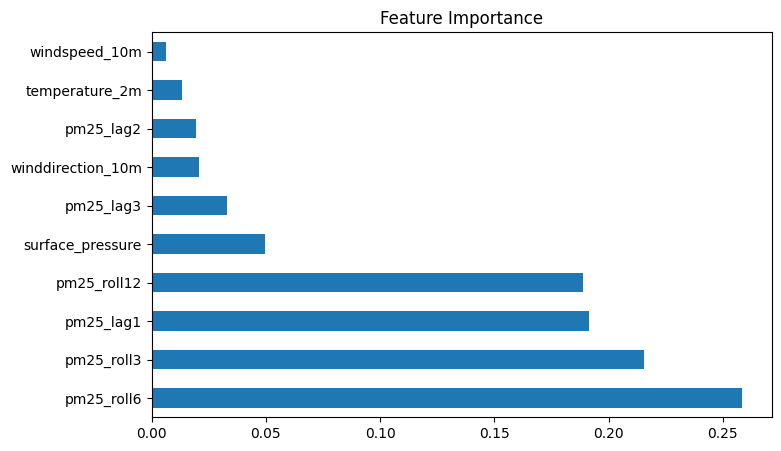

In [38]:
# Feature Importance Analysis - Check which lags or rolling averages are most important
feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp.head(10).plot(kind='barh', title='Feature Importance', figsize=(8,5))
plt.show()

In [75]:
!pip install streamlit streamlit_option_menu pyngrok streamlit-autorefresh # installation of streamlit for data visualization

In [78]:
!mkdir -p ~/.streamlit

In [79]:
%%writefile ~/.streamlit/config.toml
[theme]
base="light"
primaryColor="#2E8B57"
backgroundColor="#E8F5E9"
secondaryBackgroundColor="#C8E6C9"
textColor="#1B5E20"
font="serif"

Writing /root/.streamlit/config.toml


In [96]:
# ---------- Streamlit UI ----------
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import requests
import pickle
import matplotlib.pyplot as plt
from streamlit_autorefresh import st_autorefresh

# --- Auto-refresh dashboard every 60s ---
st_autorefresh(interval=60 * 1000, key="auto_refresh")

# --- Load trained model ---
brain = pickle.load(open('Weather.pkl', 'rb'))

# --- Page Config ---
st.set_page_config(
    page_title="🌫️PM2.5 Forecast Dashboard💨",
    page_icon="🌎",
    layout="wide",
    initial_sidebar_state="collapsed"
)

# --- Background Gradient (Eco Green theme) ---
st.markdown("""
    <style>
    .stApp {
        background: linear-gradient(180deg, #E8F5E9 0%, #C8E6C9 100%);
    }
    .css-18e3th9 {padding-top: 0rem;}
    </style>
""", unsafe_allow_html=True)

# --- Header Section ---
st.markdown("""
    <div style="text-align:center; padding: 1rem; background-color:#A5D6A7; border-radius:10px;">
        <h1 style="color:#1B5E20;">🌫️ PM2.5 Forecast Dashboard 💨</h1>
        <h4 style="color:#2E7D32;">Real-time Air Quality & Next 48-Hour Predictions</h4>
        <p style="color:#388E3C;">Stay informed. Stay safe. Powered by Machine Learning 💡</p>
    </div>
""", unsafe_allow_html=True)

# --- Feature columns ---
feature_cols = [
    'pm25_lag1','pm25_lag2','pm25_lag3',
    'pm25_roll3','pm25_roll6','pm25_roll12',
    'temperature_2m','relativehumidity_2m',
    'windspeed_10m','winddirection_10m','surface_pressure'
]

# === Function to extract datetime and PM2.5 from Open-Meteo Air Quality ===
def fetch_openmeteo_pm25(lat, lon):
    """Fetch PM2.5 for the past 72 hours (3 days) from Open-Meteo Air Quality API."""
    # Current UTC date
    end_date = datetime.now(timezone.utc)
    # Start date = Last 72 hours
    start_date = end_date - timedelta(hours=72)

    url = "https://air-quality-api.open-meteo.com/v1/air-quality"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "pm2_5",
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d"),
        "timezone": "UTC"
    }

    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    js = r.json()["hourly"]

    df = pd.DataFrame({
        "utc_time": pd.to_datetime(js["time"], utc=True),
        "pm25": js["pm2_5"]
    })
    # Keep only last 72 hours
    df = df[(df["utc_time"] >= start_date) & (df["utc_time"] <= end_date)]
    return df

# === Function to extract datetime and required variables from Open-Meteo Forecast ===
def fetch_openmeteo_weather(lat, lon):
    """Fetch hourly weather variables from Open-Meteo."""
    # Current UTC date
    end_date = datetime.now(timezone.utc)
    # Start date = Last 72 hours
    start_date = end_date - timedelta(hours=72)

    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "temperature_2m,relativehumidity_2m,windspeed_10m,winddirection_10m,surface_pressure",
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d"),
        "timezone": "UTC"
    }
    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    hourly = r.json()["hourly"]
    df = pd.DataFrame({"utc_time": pd.to_datetime(hourly["time"], utc=True)})
    for k, v in hourly.items():
        if k != "time":
            df[k] = v
    df = df[(df["utc_time"] >= start_date) & (df["utc_time"] <= end_date)]
    return df

# --- Merge PM2.5 and weather ---
lat, lon = 13.0827, 80.2707  # Example: Chennai
pm25_df = fetch_openmeteo_pm25(lat, lon)
weather_df = fetch_openmeteo_weather(lat, lon)
df = pd.merge(pm25_df, weather_df, on="utc_time", how="inner")

# --- Feature Engineering: Lags & Rolling Means ---
pm_lags = [1,2,3]  # choose lags depending on forecast horizon
for lag in pm_lags:
    df[f"pm25_lag{lag}"] = df["pm25"].shift(lag)
df['pm25_roll3'] = df['pm25'].rolling(window=3).mean()
df['pm25_roll6'] = df['pm25'].rolling(window=6).mean()
df['pm25_roll12'] = df['pm25'].rolling(window=12).mean()

# Fill any remaining NaNs with forward + backward fill
df.ffill(inplace=True)
df.bfill(inplace=True)

# --- Detect anomalies using IsolationForest ---
from sklearn.ensemble import IsolationForest
X = df[feature_cols]
# Initialize IsolationForest
iso = IsolationForest(
    n_estimators=100,      # number of trees
    contamination=0.05,    # fraction of expected anomalies (5% here)
    random_state=42
)
# Fit model
iso.fit(X)
# Predict anomalies
df['anomaly'] = iso.predict(X)  # -1 = anomaly, 1 = normal

# --- Last Observed PM2.5 ---
last_row = df.iloc[-1]

# --- Next Hour Forecast ---
X_input = pd.DataFrame([last_row[feature_cols]], columns=feature_cols)
# Reorder columns to match training order
X_input = X_input[brain.feature_names_in_]
next_hour_pred = brain.predict(X_input)[0]

# --- Metric Cards ---
col1, col2 = st.columns(2)
with col1:
    st.metric("🌤️ Last Observed PM2.5", f"{last_row['pm25']:.2f} µg/m³")
with col2:
    st.metric("🔮 Next Hour Forecast", f"{next_hour_pred:.2f} µg/m³")

# --- Air Quality Status ---
if next_hour_pred <= 50:
    st.success("🟢 Air Quality: Good")
elif next_hour_pred <= 100:
    st.info("🟡 Air Quality: Moderate")
elif next_hour_pred <= 150:
    st.warning("🟠 Air Quality: Unhealthy for Sensitive Groups")
else:
    st.error("🔴 Air Quality: Unhealthy")

# --- Recursive forecast for 24–48h ---
forecast_hours = st.slider("⏱️ Select Forecast Horizon (hours)", 1, 48, 24)
predictions = []
forecast_times = []
temp_row = last_row.copy()
for i in range(forecast_hours):
    X_input = pd.DataFrame([temp_row[feature_cols]], columns=feature_cols)
    # Reorder columns to match training order
    X_input = X_input[brain.feature_names_in_]
    y_pred = brain.predict(X_input)[0]
    predictions.append(y_pred)
    forecast_times.append(temp_row['utc_time'])

    # Update lags for next iteration
    temp_row['pm25_lag3'] = temp_row['pm25_lag2']
    temp_row['pm25_lag2'] = temp_row['pm25_lag1']
    temp_row['pm25_lag1'] = y_pred

    # Update rolling mean if used
    temp_row['pm25_roll3'] = np.mean([temp_row['pm25_lag1'], temp_row['pm25_lag2'], temp_row['pm25_lag3']])
    temp_row['pm25_roll6'] = (temp_row['pm25_roll6']*5 + y_pred)/6  # simple rolling update
    temp_row['pm25_roll12'] = (temp_row['pm25_roll12']*11 + y_pred)/12  # simple rolling update

    # Update utc_time
    temp_row['utc_time'] += pd.Timedelta(hours=1)

# --- Create Forecast DataFrame ---
forecast_df = pd.DataFrame({
    'utc_time': forecast_times,
    'pm25_pred': predictions
})
# --- Line chart: Historical + Forecast + Anomalies ---
st.subheader(f"{forecast_hours}-Hour PM2.5 Forecast")
plt.figure(figsize=(12,5))
plt.plot(df['utc_time'], df['pm25'], label='Actual PM2.5', color='blue')
plt.plot(forecast_df['utc_time'], forecast_df['pm25_pred'], label='Predicted PM2.5', color='orange')

# Highlight anomalies
anomalies = df[df['anomaly']==-1]
plt.scatter(anomalies['utc_time'], anomalies['pm25'], color='red', marker='x', label='Anomaly')

plt.xlabel("Time")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.grid(True)
st.pyplot(plt)

# --- Feature Importance ---
st.subheader("🌿 Feature Importance Ranking")
import numpy as np
importances = brain.feature_importances_
importance_df = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": np.round(importances, 3)
}).sort_values(by="Importance", ascending=False)
st.bar_chart(importance_df.set_index("Feature"))

# --- Footer ---
st.markdown("""
    <hr>
    <div style='text-align:center;color:#1B5E20;'>
        Made with ❤️ by <b>Suhail Sharif</b> | Powered by Streamlit & Open-Meteo API 🌍
    </div>
""", unsafe_allow_html=True)

Overwriting app.py


In [99]:
# Used pyngrok to access a temporary cloud machine for hosting the app
from pyngrok import ngrok
import os

# Kill any existing tunnels
ngrok.kill()

# Set the port for Streamlit
port = 8501

# Start ngrok tunnel
ngrok.set_auth_token("31b0GFSDQJdb3qvFwy3aIhzPsK9_6J68bQWQVk4qUZDd7XuwC")
public_url = ngrok.connect(port)
print("Streamlit public URL:", public_url)

# Run Streamlit app in the background
os.system(f"streamlit run app.py --server.port {port} &")

Streamlit public URL: NgrokTunnel: "https://bc457e47b40d.ngrok-free.app" -> "http://localhost:8501"


0

In [100]:
# Termination of tunnel - Stop the app
ngrok.kill()

In [59]:
# Retraining model script
%%writefile retrain_model.py
import pandas as pd
import os
from datetime import datetime, timedelta, timezone
import requests
from sklearn.ensemble import GradientBoostingRegressor
import pickle
import time

# --- Feature columns ---
feature_cols = [
    'pm25_lag1','pm25_lag2','pm25_lag3',
    'pm25_roll3','pm25_roll6','pm25_roll12',
    'temperature_2m','relativehumidity_2m',
    'windspeed_10m','winddirection_10m','surface_pressure'
    ]

# === Function to extract datetime and PM2.5 from Open-Meteo Air Quality ===
def fetch_openmeteo_pm25(lat, lon):
    """Fetch PM2.5 for the past 72 hours (3 days) from Open-Meteo Air Quality API."""
    # Current UTC date
    end_date = datetime.now(timezone.utc)
    # Start date = Last 72 hours
    start_date = end_date - timedelta(hours=72)

    url = "https://air-quality-api.open-meteo.com/v1/air-quality"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "pm2_5",
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d"),
        "timezone": "UTC"
    }

    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    js = r.json()["hourly"]

    df = pd.DataFrame({
        "utc_time": pd.to_datetime(js["time"], utc=True),
        "pm25": js["pm2_5"]
    })
    # Keep only last 72 hours
    df = df[(df["utc_time"] >= start_date) & (df["utc_time"] <= end_date)]
    return df

# === Function to extract datetime and required variables from Open-Meteo Forecast ===
def fetch_openmeteo_weather(lat, lon):
    """Fetch hourly weather variables from Open-Meteo."""
    # Current UTC date
    end_date = datetime.now(timezone.utc)
    # Start date = Last 72 hours
    start_date = end_date - timedelta(hours=72)

    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "temperature_2m,relativehumidity_2m,windspeed_10m,winddirection_10m,surface_pressure",
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d"),
        "timezone": "UTC"
    }
    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    hourly = r.json()["hourly"]
    df = pd.DataFrame({"utc_time": pd.to_datetime(hourly["time"], utc=True)})
    for k, v in hourly.items():
        if k != "time":
            df[k] = v
    df = df[(df["utc_time"] >= start_date) & (df["utc_time"] <= end_date)]
    return df

def retrain():
    # --- Merge PM2.5 and weather ---
    lat, lon = 13.0827, 80.2707  # Chennai
    pm25_df = fetch_openmeteo_pm25(lat, lon)
    weather_df = fetch_openmeteo_weather(lat, lon)
    df = pd.merge(pm25_df, weather_df, on="utc_time", how="inner")
    # --- Feature Engineering: Lags & Rolling Means ---
    pm_lags = [1,2,3]  # choose lags depending on forecast horizon
    for lag in pm_lags:
      df[f"pm25_lag{lag}"] = df["pm25"].shift(lag)
    df['pm25_roll3'] = df['pm25'].rolling(window=3).mean()
    df['pm25_roll6'] = df['pm25'].rolling(window=6).mean()
    df['pm25_roll12'] = df['pm25'].rolling(window=12).mean()
    # --- Ensured target is shifted properly to predict next hour’s PM2.5 ---
    df['target_pm25'] = df['pm25'].shift(-1)
    # --- Fill any remaining NaNs with forward + backward fill ---
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    # --- Defined Features and Target columns ---
    # Target variable
    y = df['target_pm25']
    # Feature variables (exclude utc_time and pm25 itself)
    X = df.drop(columns=['utc_time', 'pm25', 'target_pm25'], errors='ignore')
    # --- Splited data into Train and Test (train_test_split) ---
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42) # Used the first 80% for training and the last 20% for testing.
    # --- Retrain model ---
    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_train, y_train)
    # --- Save model safely ---
    with open("Weather_temp.pkl", "wb") as f:
        pickle.dump(model, f)
    os.replace("Weather_temp.pkl", "Weather.pkl")
    print(f"Model retrained at {datetime.now()}")

# --- Run once ---
retrain()

Overwriting retrain_model.py


In [77]:
# Scheduled retrain_model.py every 1 min to update model with web-scraped data
import time

while True:
    !python retrain_model.py
    time.sleep(60)  # wait for 60 seconds

Model retrained at 2025-10-15 09:55:35.489549
Model retrained at 2025-10-15 09:56:40.090159
Model retrained at 2025-10-15 09:57:44.229099
Model retrained at 2025-10-15 09:58:48.307717
Model retrained at 2025-10-15 09:59:52.988954


KeyboardInterrupt: 